# U-Net on Severstal Steel Defect Detection

The following notebook has been forked and modified from various notebooks shared publicly by xhlulu (https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate) for the Severstal Steel Defect Detection Kaggle Challenge. 

### About this kernel

This offers a boilerplate for a complete workflow for the Severstal Steel Defect Detection challenge. The popular U-Net architecture* in Keras is being used here, and other models have also been used for experimentation.

#### References

* Data generator: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
* RLE encoding and decoding: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
* Architecture: https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
* Mask encoding: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data
* Source for `bce_dice_loss`: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [6]:
import os
import json

import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


# Utility Functions

Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

## Mask encoding and decoding

In [88]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    '''
    Takes in the RLE of one image, creates a 1/0 mask, and returns the reshaped image.
    
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T   
    #return np.flipud(np.rot90(img.reshape(256,1600),k=1))

In [89]:
def build_masks(rles, input_shape):
    """
    Takes in RLEs (rles: EncodedPixels) of one image with all 4 defects, and creates
    zero masks for that image in the same shape as input_shape
    """
    depth = len(rles)   #4
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        """Looping for each of the 4 types of defects"""
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width,height))
        else:
            masks[:,:,i] = np.nan
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [129]:
def percent_mask_per_image(mask):
    """
    Takes in a mask tuple of shape (height, width, 4), creates a dataframe for each of the
    4 defect masks and returns a dictionary of percentages of each of the 4 defect masks
    """
    
    percentage = dict()
    for i in range(4):
        
        mask_df_defect = pd.DataFrame(mask[:,:,i])
        percentage[i] = mask_df_defect.sum().sum() / (mask_df_defect.shape[0] * mask_df_defect.shape[1])

    return percentage

## Loss Function

Source for `bce_dice_loss`: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/

In [96]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Preprocessing

In [7]:
train_df = pd.read_csv('./train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [65]:
#mask_count_df has the number of defect types per image

mask_count_df = train_df.groupby('ImageId').agg(np.sum)
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
mask_count_df.rename(columns={'hasMask':'num_total_masks'}, inplace=True)
mask_count_df.reset_index(inplace=True)

print(mask_count_df.head())
print(mask_count_df.shape)

         ImageId  num_total_masks
0  db4867ee8.jpg              3.0
1  ef24da2ba.jpg              3.0
2  7f30b9c64.jpg              2.0
3  bf0c81db6.jpg              2.0
4  c314f43f3.jpg              2.0
(12568, 2)


In [9]:
encoded_train_df = train_df[train_df.hasMask == True]
mask_1 = encoded_train_df[encoded_train_df.ClassId == '1']
mask_1.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
20,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,000a4bcdd.jpg,1,True
56,002fc4e19.jpg_1,146021 3 146275 10 146529 40 146783 46 147038 ...,002fc4e19.jpg,1,True
136,008ef3d74.jpg_1,356336 4 356587 11 356838 18 357089 25 357340 ...,008ef3d74.jpg,1,True
148,00ac8372f.jpg_1,101742 3 101998 12 102253 19 102301 22 102509 ...,00ac8372f.jpg,1,True


In [10]:
sub_df = pd.read_csv('./sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [ ]:
#For encoding all images with the masks 
for i in range(4):
    mask_count_df['defect_%d_percentage' %i] = 0

for x, name in enumerate(mask_count_df['ImageId']):
    filename = name
    image_df = train_df[train_df['ImageId'] == filename]

    rles = image_df['EncodedPixels'].values
    mask = build_masks(rles, (256,1600))
    percent_mask = percent_mask_per_image(mask)
    
    for i in range(2,6):
        mask_count_df.iloc[x, i] = percent_mask[i-2]

In [85]:
mask_count_df.head()

,ImageId,num_total_masks,defect_0_percentage,defect_1_percentage,defect_2_percentage,defect_3_percentage
0,db4867ee8.jpg,3.0,0.008337,0.002966,0.007500,0.000000
1,ef24da2ba.jpg,3.0,0.001787,0.005164,0.014290,0.000000
2,7f30b9c64.jpg,2.0,0.000000,0.000000,0.037463,0.035071
3,bf0c81db6.jpg,2.0,0.000000,0.000000,0.068547,0.079917
4,c314f43f3.jpg,2.0,0.000000,0.000000,0.008223,0.110681


In [86]:
mask_count_df.describe()

,num_total_masks,defect_0_percentage,defect_1_percentage,defect_2_percentage,defect_3_percentage
count,12568.000000,12568.000000,12568.000000,12568.000000,12568.000000
mean,0.564529,0.000760,0.000162,0.025507,0.005349
std,0.560757,0.003605,0.001342,0.066735,0.027432
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.020638,0.000000
max,3.000000,0.076423,0.034236,0.899023,0.470654


# Exploratory Data Analysis

## Sample Test

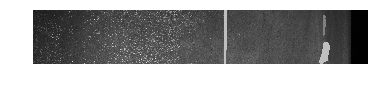

"\nfig, axs = plt.subplots(5, figsize=(12, 12))\naxs[0].imshow(sample_img)\naxs[0].axis('off')\n\nfor i in range(4):\n    axs[i+1].imshow(sample_masks[:, :, i])\n    axs[i+1].axis('off')"

In [92]:
sample_filename = 'db4867ee8.jpg'
sample_image_df = train_df[train_df['ImageId'] == sample_filename]
sample_path = f"./Train images/{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)            # image to grey
sample_rles = sample_image_df['EncodedPixels'].values
#sample_masks = build_masks(sample_rles, input_shape=(256, 1600))
mask = build_masks(sample_rles, (256,1600))

#plt.imshow(sample_img, cmap='hot')
colors = [191, 127, 191, 255]

for i in range(4):
    """Filling in each of the four defects in the picture"""
    ind_mask = mask[:,:,i]
    sample_img[ind_mask==1] = colors[i]
    plt.imshow(sample_img, cmap='twilight_shifted')
    plt.axis('off')
    
plt.show()

"""
fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')"""

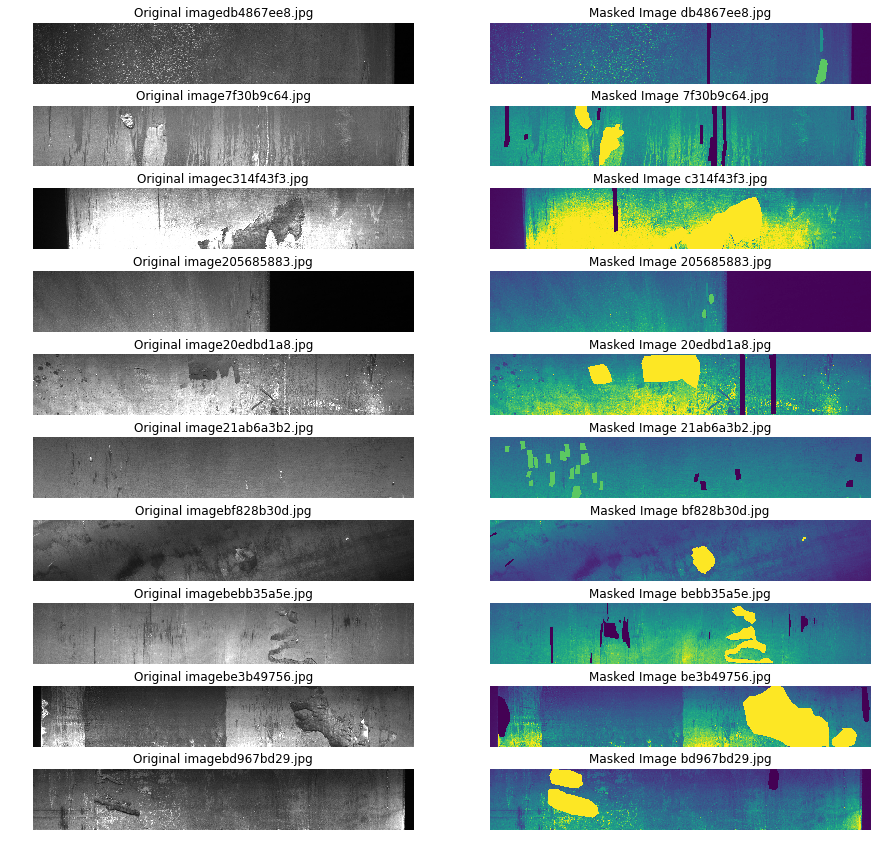

In [84]:
colors = [191, 127, 0, 255]
plt.figure(figsize=(15,15))
img_ax = dict()
img_ax_org = dict()

for y in range(0,19):
    if y % 2 == 0:
        image_df = train_df[train_df['ImageId'] == mask_count_df.ImageId[y]]
        path = f"./Train images/{image_df['ImageId'].iloc[0]}"
        img = cv2.imread(path)
        altered_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)            # image to grey
        rles = image_df['EncodedPixels'].values
        mask = build_masks(rles, (256,1600))
        
        img_ax[y] = plt.subplot(10,2,y+1)
        img_ax[y].imshow(img)
        plt.title('Original image' + mask_count_df.ImageId[y])
        img_ax[y].axis('off')
        
        img_ax[y] = plt.subplot(10,2,y+2)
        for i in range(4):
            """Filling in each of the four defects in the picture"""
            ind_mask = mask[:,:,i]
            altered_img[ind_mask==1] = colors[i]
            img_ax[y].imshow(altered_img)
            plt.title('Masked Image ' + mask_count_df.ImageId[y])
            img_ax[y].axis('off')
            
    if y == 19:
        break
        
plt.show()

In [11]:
num_defects_types = train_df.groupby('ClassId').sum().rename(columns={'hasMask':'num_defects'})
num_defects_types

,num_defects
ClassId,
1,897.0
2,247.0
3,5150.0
4,801.0


In [12]:
train_df.groupby('ClassId').count()

,ImageId_ClassId,EncodedPixels,ImageId,hasMask
ClassId,,,,
1,12568,897,12568,12568
2,12568,247,12568,12568
3,12568,5150,12568,12568
4,12568,801,12568,12568


Text(0, 0.5, 'Percentage of images')

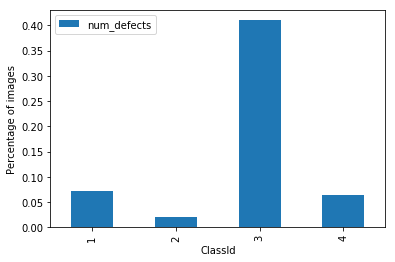

In [97]:
#Percentage of area covered by each of the defects

percent_defects = num_defects_types/12568                     #Total number of images 
percent_defects.plot(kind = 'bar')
plt.ylabel('Percentage of images')

About 40% of all photos in the training set display defect of the third type. Hence it is an important parameter that warrants detection.

The number of zero-values present in defect 1 are 11671
The number of zero-values present in defect 2 are 12321
The number of zero-values present in defect 3 are 7418
The number of zero-values present in defect 4 are 11767


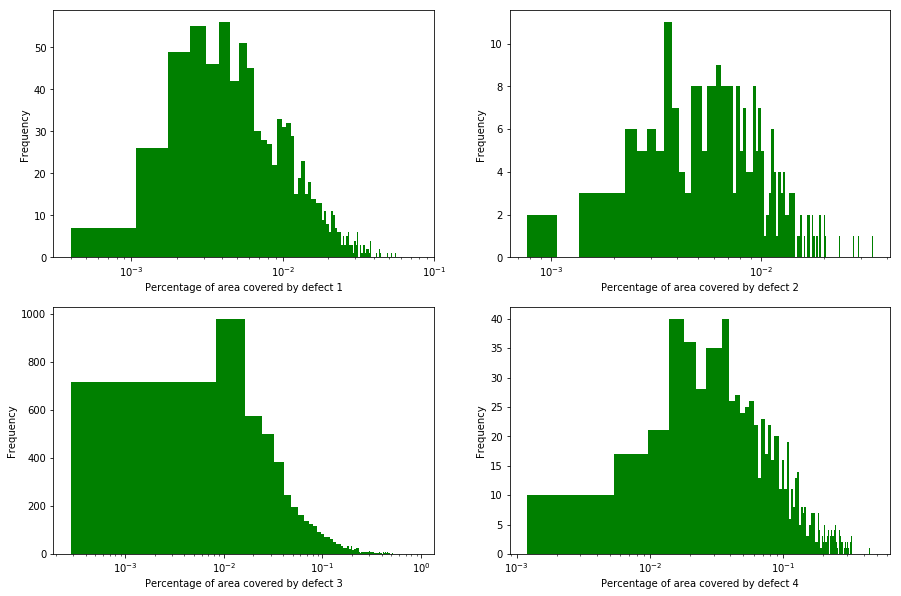

In [87]:
plt.figure(figsize=(15,10))
ax = dict()
for i in range(4):
    ax[i] = plt.subplot(2,2,i+1)
    defect_column = mask_count_df['defect_{}_percentage'.format(i)]
    label = (defect_column == 0).sum()
    ax[i].hist(defect_column[defect_column > 0], log=True, bins=int(np.sqrt(12568)), color='green') 
    
    plt.xscale('log')
    plt.yscale('linear')
    plt.xlabel('Percentage of area covered by defect {}'.format(i+1))
    plt.ylabel('Frequency')
    print('The number of zero-values present in defect {} are '.format(i+1) + str(label))

The areas covered by both defects 3 and 4 occupy major portions of the image (between 0.01 and 0.1% of the total area), whereas defects 1 and 2 occupy tinier portions. 

# Data Generator

In [93]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='./Train images/',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [249]:
BATCH_SIZE = 32

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

# Model Architecture

The following model is directly taken from this awesome kernel: https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data

In [241]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

# Training

Unhide below to see full summary:

In [242]:
model = build_model((256, 1600, 1))
model.summary()

W0910 18:12:14.631497 20936 deprecation_wrapper.py:119] From C:\Users\shubh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0910 18:12:14.705426 20936 deprecation_wrapper.py:119] From C:\Users\shubh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0910 18:12:14.730409 20936 deprecation_wrapper.py:119] From C:\Users\shubh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0910 18:12:14.779357 20936 deprecation_wrapper.py:119] From C:\Users\shubh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0910 18:12:15.192968 20936 deprecation_wrapper.py:119] From C:\Users\shubh\Ana

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [250]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=7
)

Epoch 1/7


128/333 [==========>...................] - ETA: 4:04:56 - loss: -29324488704.0000 - dice_coef: 8.2475e-0 - ETA: 3:45:05 - loss: -29188827136.0000 - dice_coef: 8.2129e-0 - ETA: 3:31:56 - loss: -29591733589.3333 - dice_coef: 8.1063e-0 - ETA: 3:24:27 - loss: -29524790272.0000 - dice_coef: 8.0356e-0 - ETA: 3:19:30 - loss: -29269272985.6000 - dice_coef: 7.9530e-0 - ETA: 3:16:15 - loss: -29412493653.3333 - dice_coef: 7.8974e-0 - ETA: 3:13:29 - loss: -29398848950.8571 - dice_coef: 7.8836e-0 - ETA: 3:11:23 - loss: -29322708992.0000 - dice_coef: 7.7983e-0 - ETA: 3:09:54 - loss: -29353107683.5556 - dice_coef: 7.7044e-0 - ETA: 3:09:08 - loss: -29269671731.2000 - dice_coef: 7.6961e-0 - ETA: 3:07:37 - loss: -29323542900.3636 - dice_coef: 7.6381e-0 - ETA: 3:06:15 - loss: -29278777002.6667 - dice_coef: 7.6488e-0 - ETA: 3:05:03 - loss: -29344428977.2308 - dice_coef: 7.5980e-0 - ETA: 3:03:53 - loss: -29400449609.1429 - dice_coef: 7.5547e-0 - ETA: 3:02:46 - loss: -29377320277.3333 - dice_coef: 7.5478e-0

KeyboardInterrupt: 

# Evaluation & Submission

In [251]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

NameError: name 'history' is not defined

In [15]:
model.load_weights('model.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

500/500 [==============================] - 7s 14ms/step


500it [00:08, 56.51it/s]

  1/500 [..............................] - ETA: 11s

500/500 [==============================] - 6s 13ms/step


500it [00:08, 56.31it/s]

  1/500 [..............................] - ETA: 9s

500/500 [==============================] - 7s 13ms/step


500it [00:08, 56.00it/s]

  1/301 [..............................] - ETA: 5s

301/301 [==============================] - 4s 13ms/step


301it [00:05, 55.46it/s]


In [16]:
test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('submission.csv', index=False)